In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [84]:
# 拆分文件，输入文件路径返回I，ib,id
class DataProcess:
    def __init__(self, file_path=r'E:\SIOA\Program\PersonalProfit\SolarEnergy\HH.csv'):
        self.file_path = file_path
        self.data_I = []
        self.data_Ib = []
        self.data_Id = []
        
        self.extract_engine()
        
    def extract_engine(self):
        data_pd = pd.read_csv(self.file_path,names=['T_'+str(i) for i in range(24)])
        self.data_I = data_pd.loc[data_pd.index%9 == 0]
        self.data_Ib = data_pd.loc[data_pd.index%9 == 1]
        self.data_Id = data_pd.loc[data_pd.index%9 == 2]
        self.data_I.index = [i for i in range(self.data_I.shape[0])]
        self.data_Ib.index = [i for i in range(self.data_Ib.shape[0])]
        self.data_Id.index = [i for i in range(self.data_Id.shape[0])]
        

In [89]:
# 输入气象条件，计算天空各向同性模型在不同斜面倾斜角度和方位角的基础上的年总辐照量总和
class SolarEnergy:
    def __init__(self, data_processor, albedo=0.2, latitude=26.207):
        self.data_I = data_processor.data_I.values
        self.data_Ib = data_processor.data_Ib.values
        self.data_Id = data_processor.data_Id.values
        # 地面反射率
        self.albedo = albedo
        # 纬度
        self.latitude = latitude
        # 时角
        self.hour_angle_w = [-180+15*i for i in range(24)]
        # 组件斜面角， 方位角
        self.bata_bevel_beta = [angle for angle in range(91)]
        self.gamma_azimuth_angle = [angle for angle in range(361)]
        
    # 弧度转角度
    @staticmethod
    def rad_2_angle(rad):
        return rad*180/np.pi
    
    # 角度转弧度
    @staticmethod
    def angle_2_rad(angle):
        return angle*np.pi/180
    
    # 计算日出日落时角wsr,wss，
    # 输入纬度latitude 和 赤纬角declination_angle_delta, -- ok
    def cal_sunrise_sunset_w(self, latitude, declination_angle_delta):
        cos_w = -np.tan(self.angle_2_rad(latitude))*np.tan(self.angle_2_rad(declination_angle_delta))
        wsr = -np.abs(np.arccos(cos_w))
        wss = -wsr
        return self.rad_2_angle(wsr),self.rad_2_angle(wss)
    
    # 计算赤纬角declination_angle_delta，
    # 输入n(一年中第多少天) ----ok
    def cal_declination_angle_delta(self, n):
        rad_sun_angle = 2*np.pi*(n-1)/365.0
        delta = (0.006918 - 0.399912*np.cos(rad_sun_angle) + 0.070257*np.sin(rad_sun_angle) 
                 - 0.006758*np.cos(2*rad_sun_angle) + 0.000907*np.sin(2*rad_sun_angle) 
                 - 0.002697*np.cos(3*rad_sun_angle) + 0.00148*np.sin(3*rad_sun_angle))*180/np.pi
        # delta = np.arcsin(0.4*np.sin(self.angle_2_rad(360.0*(n-82)/365)))
        # return self.rad_2_angle(delta)
        return delta
        
    # 计算太阳高度角alpha_s的sin值, -- ok
    # 输入纬度latitude、赤纬角declination_angle_delta、时角hour_angle  
    def cal_sin_alpha_s(self,latitude, declination_angle_delta,hour_angle):
        rad_latitude = self.angle_2_rad(latitude)
        rad_declination_angle_delta = self.angle_2_rad(declination_angle_delta)
        rad_hour_angle = self.angle_2_rad(hour_angle)
        res_val = np.sin(rad_latitude)*np.sin(rad_declination_angle_delta) + \
                  np.cos(rad_latitude)*np.cos(rad_declination_angle_delta)*np.cos(rad_hour_angle)
        return res_val
    
    # 计算太阳方位角gamma_s的sin和cos值，--ok
    # 输入纬度、赤纬角  
    def cal_gammas_sin_cos(self, latitude, declination_angle_delta, hour_angle):
        rad_latitude = self.angle_2_rad(latitude)
        rad_declination_angle_delta = self.angle_2_rad(declination_angle_delta)
        rad_hour_angle = self.angle_2_rad(hour_angle)
        sin_alpha_s = self.cal_sin_alpha_s(latitude,declination_angle_delta,hour_angle)
        # 如果计算出来不准确也只可能是这里的问题，角度转换问题
        cos_alpha_s = np.cos(np.arcsin(sin_alpha_s))
        cos_gamma_s = (sin_alpha_s*np.sin(rad_latitude) - np.sin(rad_declination_angle_delta))/(cos_alpha_s*np.cos(rad_latitude))
        sin_gamma_s = np.cos(rad_declination_angle_delta)*np.sin(rad_hour_angle)/cos_alpha_s
        return sin_gamma_s, cos_gamma_s

    # 计算天顶角theta_z的cos值， --ok
    # 输入纬度、赤纬角、时角
    def cal_cos_theta_z(self, latitude,declination_angle_delta, hour_angle):
        rad_latitude = self.angle_2_rad(latitude)
        rad_declination_angle_delta = self.angle_2_rad(declination_angle_delta)
        rad_hour_angle = self.angle_2_rad(hour_angle)
        cos_theta_z = np.cos(rad_latitude)*np.cos(rad_declination_angle_delta)*np.cos(rad_hour_angle) \
                      + np.sin(rad_latitude)*np.sin(rad_declination_angle_delta)
        return cos_theta_z
    
    # 计算入射角theta的cos值，
    # 输入纬度、赤纬角、时角、斜面角beta,方位角gamma
    def cal_cos_theta(self, latitude,declination_angle_delta, hour_angle,beta,gamma):
        rad_beta = self.angle_2_rad(beta)
        rad_gamma = self.angle_2_rad(gamma)
        
        cos_theta_z = self.cal_cos_theta_z(latitude,declination_angle_delta, hour_angle)
        sin_theta_z = np.sin(np.arccos(cos_theta_z))
        
        sin_gamma_s, cos_gamma_s = self.cal_gammas_sin_cos(latitude, declination_angle_delta, hour_angle)
        cos_theta = cos_theta_z*np.cos(rad_beta)\
                    + sin_theta_z*np.sin(rad_beta)*(cos_gamma_s*np.cos(rad_gamma) + sin_gamma_s*np.sin(rad_gamma))
        return cos_theta
    
    # 计算一个小时的辐照总量，
    # 输入I,Ib,Id,纬度、赤纬角、时角、斜面角beta,方位角gamma
    def cal_total_solar_hourly(self, I, Ib, Id, latitude, declination_angle_delta, hour_angle,
                               beta, gamma):
        cos_theta = self.cal_cos_theta(latitude,declination_angle_delta, hour_angle,beta,gamma)
        cos_theta_z = self.cal_cos_theta_z(latitude,declination_angle_delta, hour_angle)
        Rb = cos_theta/cos_theta_z
        rad_beta = self.angle_2_rad(beta)
        return Ib*Rb + Id*(1 + np.cos(rad_beta))/2.0 + I*self.albedo*(1 - np.cos(rad_beta))/2.0
    
    # 计算在给定斜面角和方位角的配置下，年辐照总量
    def cal_total_solar_yearly(self, latitude,beta, gamma):
        res_val = 0
        for day_index in range(self.data_I.shape[0]):
            # 计算赤纬角declination_angle_delta
            declination_angle_delta = self.cal_declination_angle_delta(day_index+1)
            # 计算wsr,wss
            wsr,wss = self.cal_sunrise_sunset_w(latitude, declination_angle_delta)
            for hour_index in range(self.data_I.shape[1]):
                # 当前时角
                hour_angle = self.hour_angle_w[hour_index]
                if wsr <= hour_angle <= wss:
                    I = self.data_I[day_index][hour_index]
                    Ib = self.data_Ib[day_index][hour_index]
                    Id = self.data_Id[day_index][hour_index]
                    res_val += self.cal_total_solar_hourly(I, Ib, Id,latitude, declination_angle_delta, 
                                                           hour_angle, beta, gamma)
        return res_val
    
    # 绘制三维图
    def plot_grid(self, result_container,
                  result_save_dir=r'E:\SIOA\Program\PersonalProfit\SolarEnergy\ResultSave'):
        figure = plt.figure()
        ax = Axes3D(figure)
        X = self.bata_bevel_beta
        Y = self.gamma_azimuth_angle
        #网格化数据
        X, Y = np.meshgrid(X, Y)
        #Z = np.random.rand(X.shape[0],X.shape[1])
        Z = np.zeros([X.shape[0],X.shape[1]])
        for i in range(Z.shape[0]):
            for j in range(Z.shape[1]):
                Z[i][j] = result_container.loc[(result_container.beta == X[i][j]) & (result_container.gamma == Y[i][j])]['yearly_I']
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
        ax.set_xlabel('bata')
        ax.set_ylabel('gamma')
        ax.set_zlabel('yearly_I')
        plt.savefig(result_save_dir + r'\saved_result.jpg')
        plt.show()
    
    # 保存结果
    def save_result(self, result_container, 
                    result_save_dir=r'E:\SIOA\Program\PersonalProfit\SolarEnergy\ResultSave'):
        result_container.to_csv(result_save_dir + r'\saved_result.csv', index=None)
        print('result saved success at ' + result_save_dir + r'\saved_result.csv')
    
    # 计算在不同斜面角和方位角的配置下，年辐照总量,模型主程
    def cal_total_solar(self):
        result_container = pd.DataFrame()
        beta_container = []
        gamma_container = []
        yearly_I_container = []
        for beta in self.bata_bevel_beta:
            for gamma in self.gamma_azimuth_angle:
                solar_yearly = self.cal_total_solar_yearly(self.latitude, beta, gamma)
                beta_container.append(beta)
                gamma_container.append(gamma)
                yearly_I_container.append(solar_yearly)
            print('beta:%d'%beta)
        result_container['beta'] = beta_container
        result_container['gamma'] = gamma_container
        result_container['yearly_I'] = yearly_I_container
        print('best beta and gamma:',result_container.loc[result_container.yearly_I == result_container.yearly_I.max()])
        self.save_result(result_container)
        self.plot_grid(result_container)
        return result_container
    

In [90]:
solar_energy = SolarEnergy(data_processor=DataProcess())

beta:0
beta:5
beta:10
beta:15
beta:20
best beta and gamma:     beta  gamma       yearly_I
15    15      0  549930.898298
result saved success at E:\SIOA\Program\PersonalProfit\SolarEnergy\ResultSave\saved_result.csv


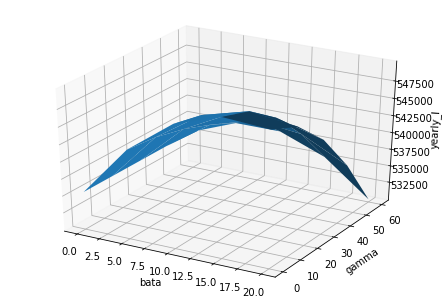

In [91]:
result_container = solar_energy.cal_total_solar()